In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import multiprocessing as mp
import random
import string

In [4]:
random.seed(123)

In [5]:
output = mp.Queue() # define a queue

In [6]:
def rand_string(length, output):
    """Generates a random string of numbers, lower and upper case characters"""
    rand_str = "".join(random.choice(string.ascii_lowercase + 
                                     string.ascii_uppercase + 
                                     string.digits)
                      for i in range(length))
    output.put(rand_str)

In [7]:
processes = [mp.Process(target=rand_string, args=(5, output)) for x in range(4)] # the list of processes we will run

In [8]:
# run processes
for p in processes:
    p.start()
    
# exit the completed processes
for p in processes:
    p.join()

In [9]:
results = [output.get() for p in processes]
print(results)

['Wcscb', 'vHIP7', 'RJANK', 'x2Az9']


###### How to retrieve results in a particular order

In [10]:
output = mp.Queue()

def rand_string(length, pos, output):
    rand_str = "".join(random.choice(string.ascii_lowercase +
                                    string.ascii_uppercase +
                                    string.digits)
                      for i in range(length))
    output.put((pos, rand_str))

In [11]:
processes = [mp.Process(target=rand_string, args=(5, x, output)) for x in range(4)]

In [12]:
for p in processes:
    p.start()

for p in processes:
    p.join()

In [13]:
results = [output.get() for p in processes]

In [14]:
results
results.sort()
results = [r[1] for r in results]
print(results)

[(0, '3MyLt'), (1, 'aV48W'), (2, '1Xhil'), (3, 'qa9xj')]

['3MyLt', 'aV48W', '1Xhil', 'qa9xj']


###### A simpler way to maintain an ordered list is to use the pool.apply and pool.map funcitions

In [15]:
def cube(x):
    return x**3

In [16]:
pool = mp.Pool(processes=4)

In [17]:
results = [pool.apply(cube, args=(x,)) for x in range(1, 7)]
results

[1, 8, 27, 64, 125, 216]

In [18]:
pool = mp.Pool(processes=4)
results = pool.map(cube, range(1, 7))

In [19]:
results

[1, 8, 27, 64, 125, 216]

Using async variants - pool.map and pool.apply will lock the main program until all processes are finished. The async variants will retrieve the results as soon as they are finished - we have to use the get method

In [20]:
pool = mp.Pool(processes=4)
results = [pool.apply_async(cube, args=(x,)) for x in range(1, 7)]

output = [p.get() for p in results]
print(output)

[1, 8, 27, 64, 125, 216]


###### Kernel density estimation as benchmarking function

In [21]:
import numpy as np

def parzen_estimation(x_samples, point_x, h):
    """
    Implementation of a hypercube kernel for parzen window estimation.
    
    Keyword arguments:
        x_sample: training sample, 'd x 1'-dimentional numpy array
        x: point x for density estimation, 'd x 1' dimentional numpy array
        h: window width
    
    Returns the predicted pdf as a float
    """
    k_n = 0
    for row in x_samples:
        x_i = (point_x - row[:, np.newaxis])/ (h)
        for row in x_i:
            if np.abs(row) > (1/2):
                break
        else: # completion else: this is only executed if the preceeding code block has finished
            k_n += 1
    return (k_n / len(x_samples)) / (h**point_x.shape[1])

In [22]:
%matplotlib inline

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from itertools import product, combinations

(-1.5, 1.5)

(-1.5, 1.5)

(-1.5, 1.5)

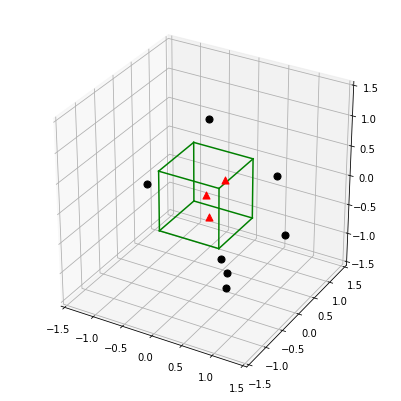

In [24]:
fig = plt.figure(figsize=(7, 7))
ax = fig.gca(projection="3d")
ax.set_aspect("equal")

X_inside = np.array([[0, 0, 0], [0.2, 0.2, 0.2], [0.1, -0.1, -0.3]])

X_outside = np.array([[-1.2,0.3,-0.3],[0.8,-0.82,-0.9],[1, 0.6, -0.7],
                      [0.8,0.7,0.2],[0.7,-0.8,-0.45],[-0.3, 0.6, 0.9],
                      [0.7,-0.6,-0.8]])

for row in X_inside:
    ax.scatter(row[0], row[1], row[2], color="r", s=50, marker='^')

for row in X_outside:    
    ax.scatter(row[0], row[1], row[2], color="k", s=50)

# Plot Cube
h = [-0.5, 0.5]
for s, e in combinations(np.array(list(product(h,h,h))), 2):
    if np.sum(np.abs(s-e)) == h[1]-h[0]:
        ax.plot3D(*zip(s,e), color="g")
        
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

plt.show()

In [25]:
point_x = np.array([[0],[0],[0]])
X_all = np.vstack((X_inside,X_outside))

print('p(x) =', parzen_estimation(X_all, point_x, h=1))

p(x) = 0.3


In [26]:
np.random.seed(123)

mu_vec = np.array([0, 0])
cov_mat = np.array([[1, 0], [0, 1]])
x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, 10000)

In [27]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[0,0], cov=[[1,0],[0,1]])
print('actual probability density:', var.pdf([0,0]))

actual probability density: 0.15915494309189535


In [28]:
def parzen_estimation(x_samples, point_x, h):
    k_n = 0
    for row in x_samples:
        x_i = (point_x - row[:,np.newaxis]) / (h)
        for row in x_i:
            if np.abs(row) > (1/2):
                break
        else: # "completion-else"*
            k_n += 1
    return (h, (k_n / len(x_samples)) / (h**point_x.shape[1]))

In [29]:
def serial(samples, x, widths):
    return [parzen_estimation(samples, x, w) for w in widths]

def multiprocess(processes, samples, x, widths):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(parzen_estimation, args=(samples, x, w)) for w in widths]
    results = [p.get() for p in results]
    results.sort() # to sort the results by input window width
    return results

In [30]:
widths = np.arange(0.1, 1.3, 0.1)
point_x = np.array([[0],[0]])
results = []

results = multiprocess(4, x_2Dgauss, point_x, widths)

for r in results:
    print('h = %s, p(x) = %s' %(r[0], r[1]))

h = 0.1, p(x) = 0.016
h = 0.2, p(x) = 0.0305
h = 0.30000000000000004, p(x) = 0.04499999999999999
h = 0.4, p(x) = 0.06175
h = 0.5, p(x) = 0.078
h = 0.6, p(x) = 0.09116666666666667
h = 0.7000000000000001, p(x) = 0.106
h = 0.8, p(x) = 0.117375
h = 0.9, p(x) = 0.13266666666666668
h = 1.0, p(x) = 0.1445
h = 1.1, p(x) = 0.1570909090909091
h = 1.2000000000000002, p(x) = 0.16849999999999996


In [31]:
widths = np.linspace(1.0, 1.2, 100)

In [32]:
import timeit

mu_vec = np.array([0,0])
cov_mat = np.array([[1,0],[0,1]])
n = 10000

x_2Dgauss = np.random.multivariate_normal(mu_vec, cov_mat, n)

benchmarks = []

benchmarks.append(timeit.Timer('serial(x_2Dgauss, point_x, widths)', 
            'from __main__ import serial, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(2, x_2Dgauss, point_x, widths)', 
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(3, x_2Dgauss, point_x, widths)', 
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(4, x_2Dgauss, point_x, widths)', 
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

benchmarks.append(timeit.Timer('multiprocess(6, x_2Dgauss, point_x, widths)', 
            'from __main__ import multiprocess, x_2Dgauss, point_x, widths').timeit(number=1))

In [33]:
import platform

def print_sysinfo():
    
    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())
    
    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', mp.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

In [34]:
from matplotlib import pyplot as plt
import numpy as np

def plot_results():
    bar_labels = ['serial', '2', '3', '4', '6']

    fig = plt.figure(figsize=(10,8))

    # plot bars
    y_pos = np.arange(len(benchmarks))
    plt.yticks(y_pos, bar_labels, fontsize=16)
    bars = plt.barh(y_pos, benchmarks,
             align='center', alpha=0.4, color='g')

    # annotation and labels
    
    for ba,be in zip(bars, benchmarks):
        plt.text(ba.get_width() + 2, ba.get_y() + ba.get_height()/2,
                '{0:.2%}'.format(benchmarks[0]/be), 
                ha='center', va='bottom', fontsize=12)
    
    plt.xlabel('time in seconds for n=%s' %n, fontsize=14)
    plt.ylabel('number of processes', fontsize=14)
    t = plt.title('Serial vs. Multiprocessing via Parzen-window estimation', fontsize=18)
    plt.ylim([-1,len(benchmarks)+0.5])
    plt.xlim([0,max(benchmarks)*1.1])
    plt.vlines(benchmarks[0], -1, len(benchmarks)+0.5, linestyles='dashed')
    plt.grid()

    plt.show()

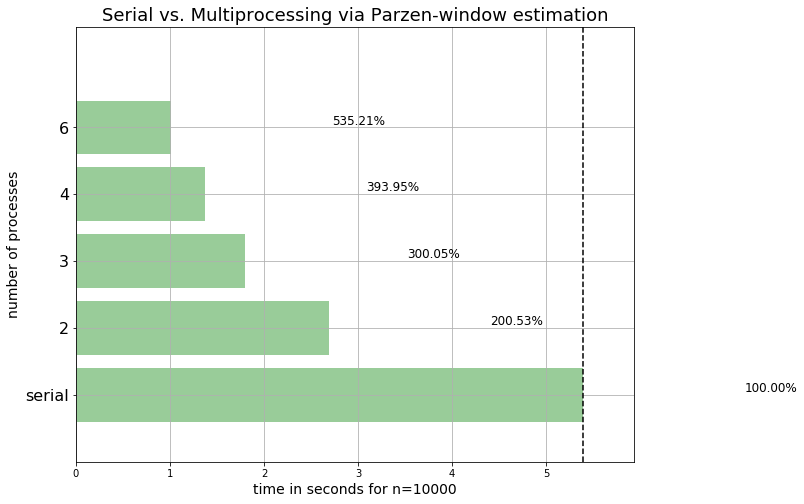


Python version  : 3.6.4
compiler        : GCC 7.2.0

system     : Linux
release    : 4.13.0-1011-azure
machine    : x86_64
processor  : x86_64
CPU count  : 12
interpreter: 64bit





In [35]:
plot_results()
print_sysinfo()